# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '../data/' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

# Your code goes here

## Task 0: Research Question

**Research question:**
*How can we mesure the retention of pubils on the platform?*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### 📊 Data-pre-processing pipeline

1. **Timestamp → calendar week**  
   * Parse `events.event_date` and `transactions.start_time` into a proper `datetime`.  
   * Derive **`year_week`** using `strftime('%Y-%U')` (Sunday-based week index, `00-53`).

2. **Weekly behavioural features** – computed per **`(user_id, year_week)`**

   | Dimension | Features |
   |-----------|----------|
   | **Effort** | `weekly_events`, `weekly_clicks`, `weekly_time_spent` |
   | **Consistency** | `mean_session_duration`, `std_weekly_activity` |
   | **Regularity** | `mean_days_between_sessions` |
   | **Proactivity** | `weekly_go_to_theory`, `weekly_early_sessions` |
   | **Control** | `weekly_next_actions`, `weekly_skip_actions` |
   | **Assessment** | `weekly_percentage_correct`, `weekly_challenges_completed` |

3. **Build `user_week_features`**  
   * Start from the unique `(user_id, year_week)` pairs in `events`.  
   * Left-join every feature dataframe above.  
   * Replace `NaN` with **0** (means “no activity that week”).  
   * Append per-user `std_weekly_activity`.

4. **Prune inactive learners**  
   * Compute per-user totals:  
     * `n_events` = all events  
     * `n_weeks`  = weeks with ≥1 event  
   * Keep users with **≥ 10 events AND ≥ 10 active weeks**.  
   * Re-filter `events`, `transactions`, `user_week_features`.

5. **Create engagement label `engaged_next_week`**  
   * “Meaningful” actions: `SUBMIT_ANSWER`, `REVIEW_TASK`, `NEXT`, `SKIP`, `GO_TO_THEORY`.  
   * For each week *t*: **1** if the same learner performs ≥ 1 meaningful action in week *t + 1*; else **0**.  
   * Merge the label into `user_week_features`.

6. **QA visual checks**  
   * Histograms / KDE for every numeric feature (seaborn).  
   * Weekly engagement-rate line chart to spot seasonal dips or spikes.

Result ⇒ **`user_week_features`**: one row per learner-week, ~25 engineered numeric features, plus the binary target **`engaged_next_week`** – ready for clustering & modelling.

is_active
False    20557
True      1913
Name: count, dtype: int64


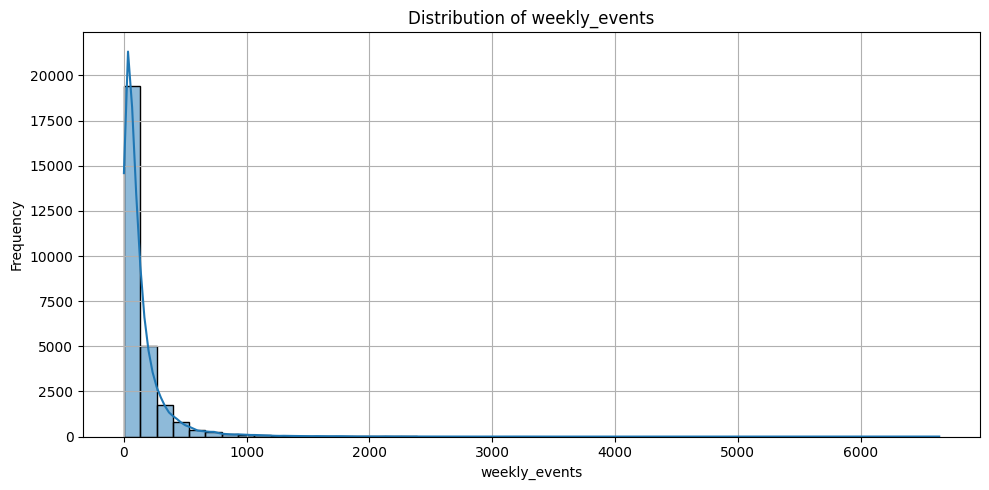

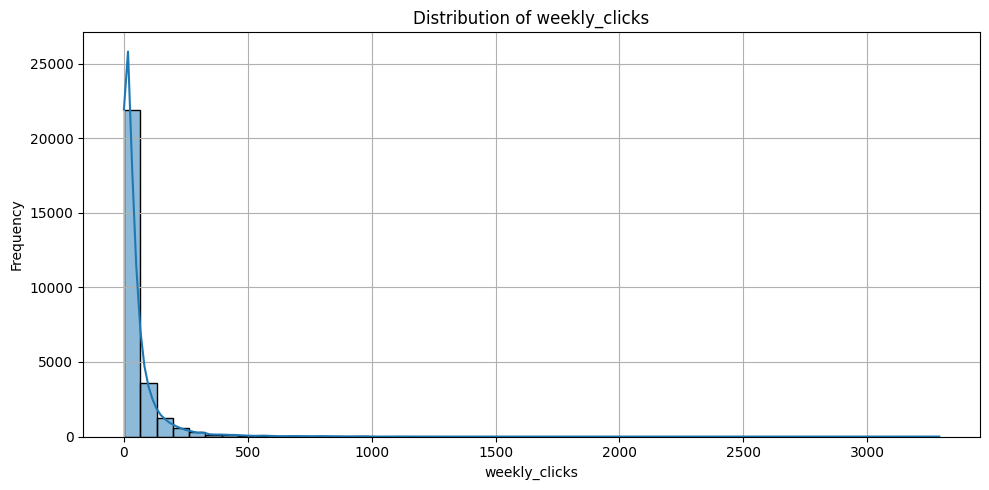

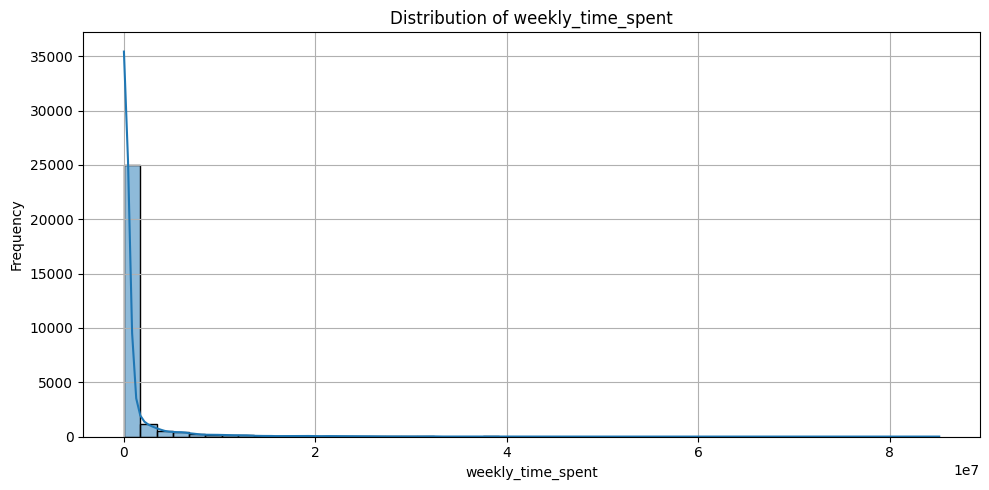

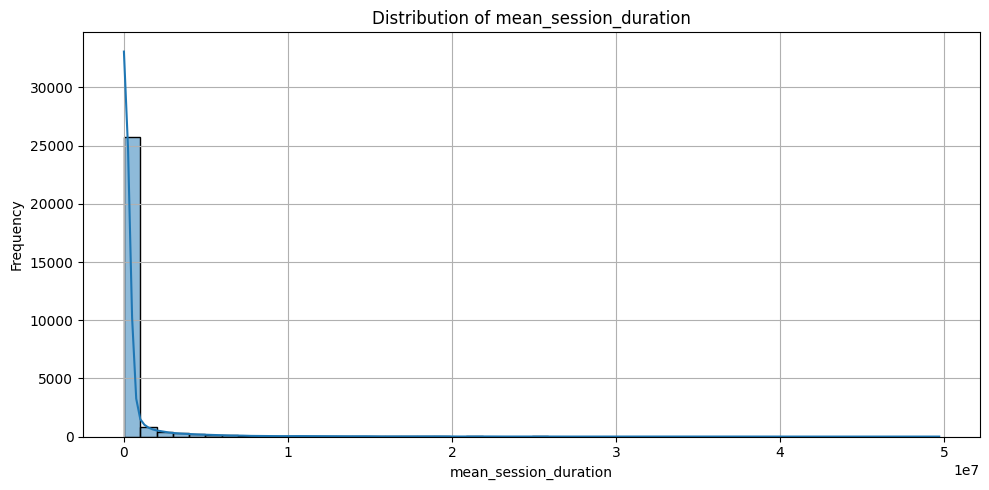

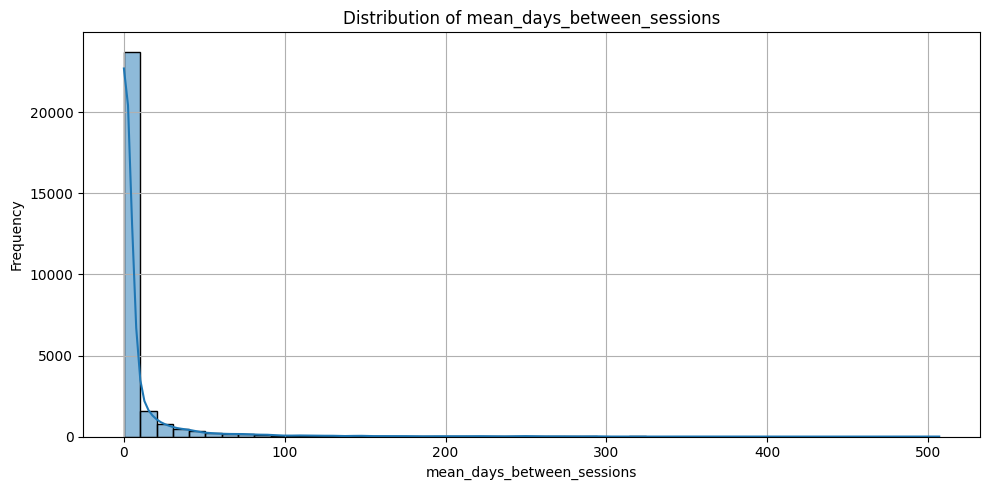

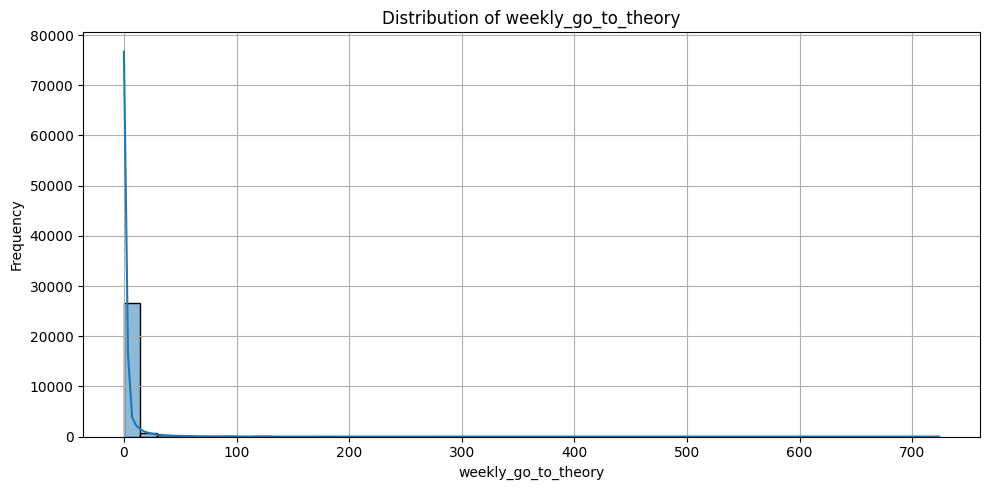

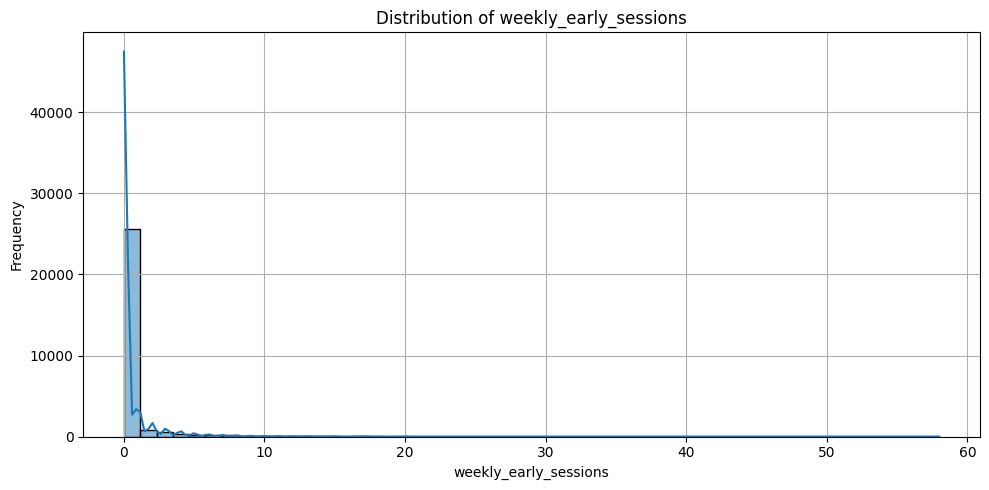

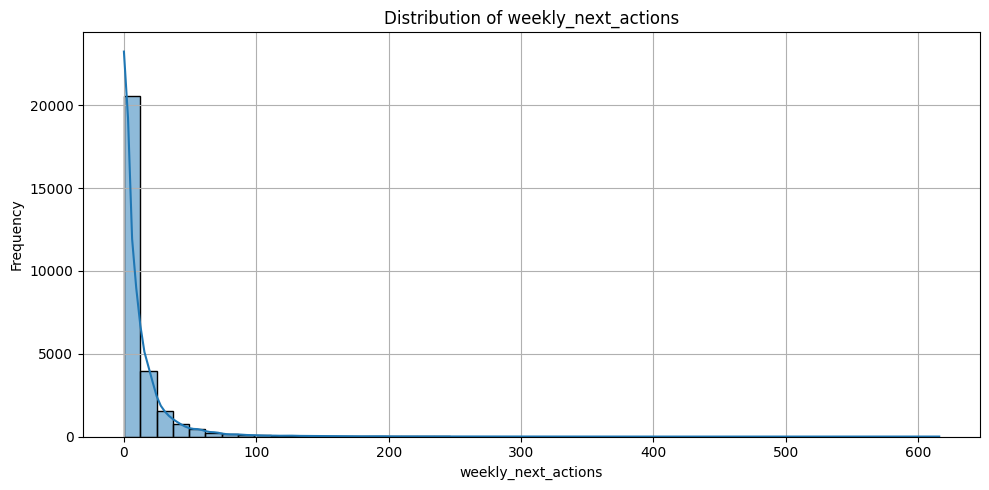

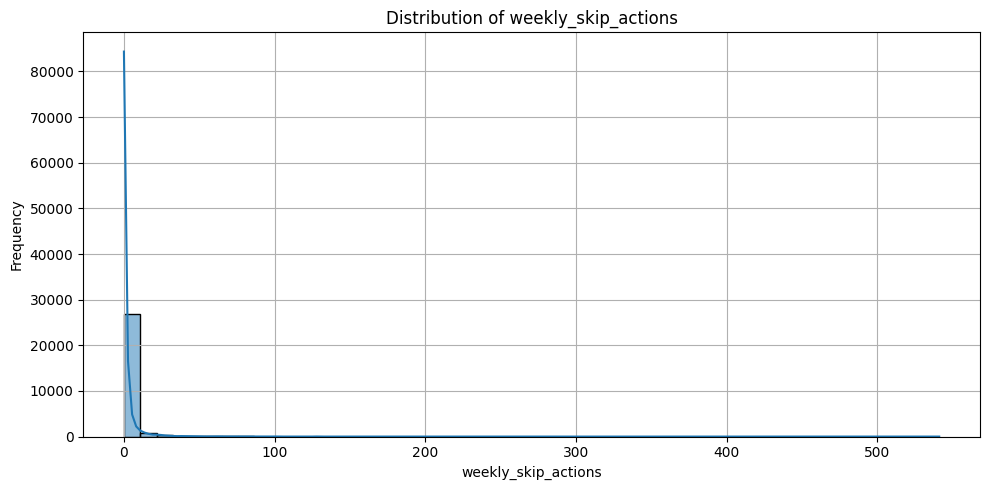

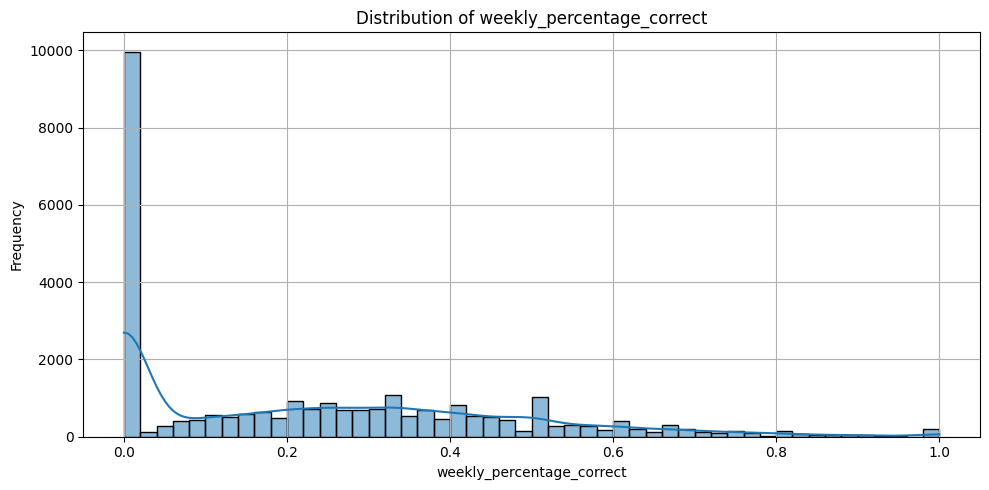

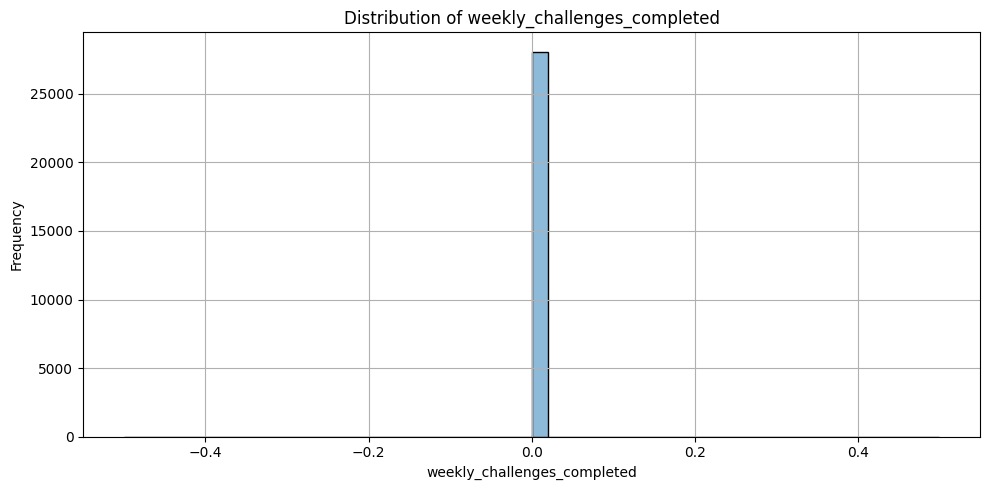

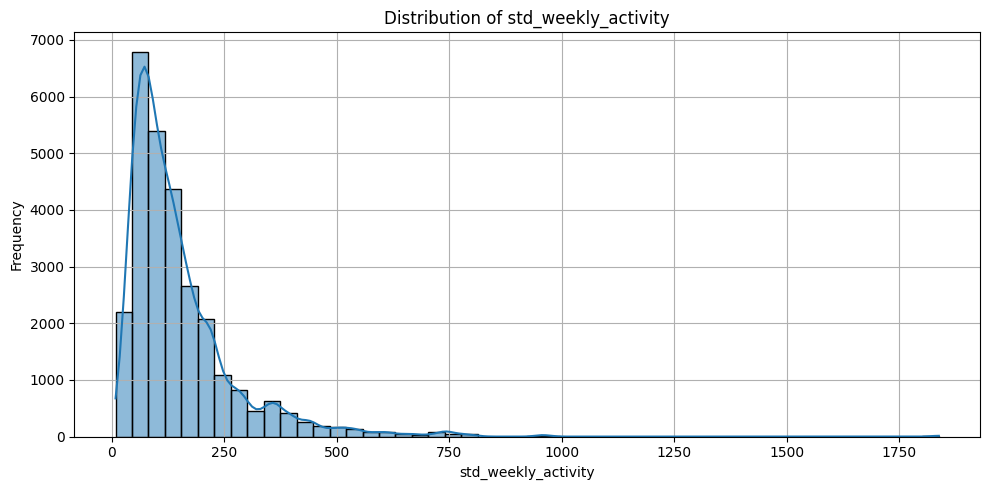

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event_date and start_time to datetime
events['date'] = pd.to_datetime(events['event_date'])
transactions['date'] = pd.to_datetime(transactions['start_time'])

# Extract year and week number
events['year_week'] = events['date'].dt.strftime('%Y-%U')
transactions['year_week'] = transactions['date'].dt.strftime('%Y-%U')

# Effort
weekly_events = events.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_events')
weekly_clicks = events[events['event_type'] == 'CLICK'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_clicks')

# Time spent per session
events = events.sort_values(by=['user_id', 'date'])
events['next_date'] = events.groupby(['user_id', 'session_id'])['date'].shift(-1)
events['session_time'] = (events['next_date'] - events['date']).dt.total_seconds()
weekly_time_spent = events.groupby(['user_id', 'year_week'])['session_time'].sum().reset_index(name='weekly_time_spent')

# Consistency
session_durations = events.groupby(['user_id', 'session_id']).agg(
    session_start=('date', 'min'),
    session_end=('date', 'max')
).reset_index()
session_durations['duration'] = (session_durations['session_end'] - session_durations['session_start']).dt.total_seconds()
session_durations['year_week'] = session_durations['session_start'].dt.strftime('%Y-%U')
mean_session_duration = session_durations.groupby(['user_id', 'year_week'])['duration'].mean().reset_index(name='mean_session_duration')

std_weekly_activity = weekly_events.groupby('user_id')['weekly_events'].std().reset_index(name='std_weekly_activity')

# Regularity
session_starts = events.groupby(['user_id', 'session_id'])['date'].min().reset_index()
session_starts = session_starts.sort_values(by=['user_id', 'date'])
session_starts['previous_session'] = session_starts.groupby('user_id')['date'].shift(1)
session_starts['days_between'] = (session_starts['date'] - session_starts['previous_session']).dt.days
session_starts['year_week'] = session_starts['date'].dt.strftime('%Y-%U')
mean_days_between_sessions = session_starts.groupby(['user_id', 'year_week'])['days_between'].mean().reset_index(name='mean_days_between_sessions')

# Proactivity
go_to_theory_actions = events[events['action'] == 'GO_TO_THEORY'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_go_to_theory')
events['hour'] = events['date'].dt.hour
early_sessions = events[events['hour'] < 8].groupby(['user_id', 'year_week'])['session_id'].nunique().reset_index(name='weekly_early_sessions')

# Control
next_actions = events[events['action'] == 'NEXT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_next_actions')
skip_actions = events[events['action'] == 'SKIP'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_skip_actions')

# Assessment
correct_evaluations = transactions[transactions['evaluation'] == 'CORRECT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_correct')
total_evaluations = transactions.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_total')
assessment = pd.merge(total_evaluations, correct_evaluations, on=['user_id', 'year_week'], how='left').fillna(0)
assessment['weekly_percentage_correct'] = assessment['weekly_correct'] / assessment['weekly_total']

challenges_completed = transactions[transactions['challenge_id'].notnull() & (transactions['session_accepted'] == 1)].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_challenges_completed')

# Combine all features
user_week_features = pd.DataFrame(events[['user_id', 'year_week']].drop_duplicates())

feature_dfs = [
    weekly_events, weekly_clicks, weekly_time_spent, mean_session_duration,
    mean_days_between_sessions, go_to_theory_actions,
    early_sessions, next_actions, skip_actions,
    assessment[['user_id', 'year_week', 'weekly_percentage_correct']], challenges_completed
]

for feature_df in feature_dfs:
    user_week_features = pd.merge(user_week_features, feature_df, on=['user_id', 'year_week'], how='left')

# Fill missing values with 0
user_week_features = user_week_features.fillna(0)

user_week_features = pd.merge(user_week_features, std_weekly_activity, on='user_id', how='left')


# -------------------------------------------------------------------
# 1.  total events per user
total_events = events.groupby('user_id').size().rename('n_events')

# 2.  active weeks per user  (we already have weekly_events)
active_weeks = weekly_events.groupby('user_id').size().rename('n_weeks')

# 3.  merge the two summaries
activity_summary = pd.concat([total_events, active_weeks], axis=1).fillna(0)

# 4.  flag "active" learners
activity_summary['is_active'] = (
        (activity_summary['n_events'] >= 10) &
        (activity_summary['n_weeks']  >= 10)
)

print(activity_summary['is_active'].value_counts())

# 1.  keep only active user_ids
active_ids = activity_summary.index[activity_summary['is_active']]

events        = events[events['user_id'].isin(active_ids)]
transactions  = transactions[transactions['user_id'].isin(active_ids)]

# 2.  because user_week_features is built *after* events filtering,
#     you can now rerun the feature-engineering cell OR
#     just filter the existing DF:
user_week_features = user_week_features[user_week_features['user_id'].isin(active_ids)]

# Visualize the features
numeric_cols = user_week_features.select_dtypes(include=['number']).columns.drop('user_id', errors='ignore')

for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(user_week_features[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Create correlation matrix to visualize relationships between features    #



In [3]:
user_week_features.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity
0,387604,2021-20,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
1,387604,2021-21,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
2,387604,2021-25,7,4.0,7.837221e+05,7.837424e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
3,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.0,0.0,0.0,0.0,7.0,0.0,0.0,141.95107
4,387604,2021-31,12,6.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107


In [5]:
user_week_features.to_csv("../data/user_week_features.csv", index=False)

In [4]:
user_week_features['week_start'] = pd.to_datetime(
        user_week_features['year_week'] + '-0',   # '-0' = Sunday
        format='%Y-%U-%w'
)
user_week_features['week_period'] = user_week_features['week_start'].dt.to_period('W-SUN')

In [5]:
# Build the year-week string in events  ------------------------------
events['year_week'] = (
    pd.to_datetime(events['event_date'])
      .dt.strftime('%Y-%U')     # <-- .dt before strftime
)

# Same idea for transactions if you need it
transactions['year_week'] = (
    pd.to_datetime(transactions['start_time'])
      .dt.strftime('%Y-%U')
)

#redundnat ? 


In [6]:

meaningful = events.query(
    "action in ['SUBMIT_ANSWER','REVIEW_TASK','NEXT','SKIP','GO_TO_THEORY']"
).copy()

meaningful['iso_week'] = pd.to_datetime(meaningful['event_date']).dt.to_period('W')

# ---------- 2  any-activity table ------------------------------------
has_activity = (meaningful
                .drop_duplicates(['user_id','iso_week'])
                .assign(active=1))

# ---------- 3  build next-week target --------------------------------
# left df = current week, right df = next week
target_df = (has_activity
             .merge(has_activity.assign(iso_week=lambda d: d['iso_week']-1),
                    on=['user_id','iso_week'],
                    how='left', suffixes=('','_next'))
             .rename(columns={'active_next':'engaged_next_week'})
             .fillna({'engaged_next_week':0})
             .loc[:, ['user_id','iso_week','engaged_next_week']])

target_df['year_week'] = (
        target_df['iso_week']          # Period[W-SUN]
                 .astype('datetime64[ns]')
                 .dt.strftime('%Y-%U') )

# ---------- 4  attach to your feature table --------------------------
user_week_features = (user_week_features
                      .merge(target_df[['user_id','year_week','engaged_next_week']],
                             on=['user_id','year_week'],
                             how='left'))

# rows with NaN in label = last observed week for that user
user_week_features = user_week_features.dropna(subset=['engaged_next_week'])
user_week_features['engaged_next_week'] = (
    user_week_features['engaged_next_week'].astype('int8')
)

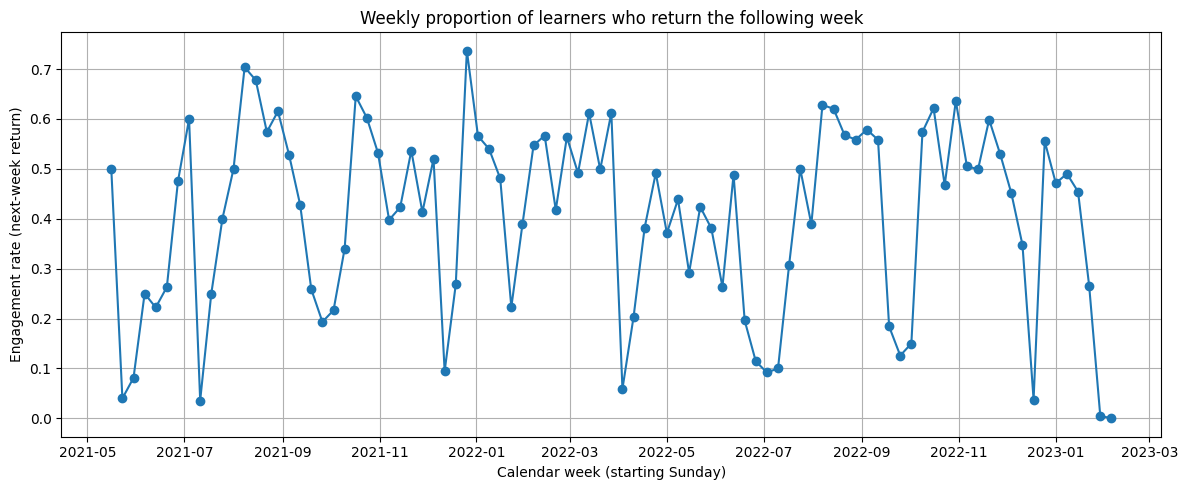

In [7]:
# ---------- Expect `user_week_features` in memory --------------------
try:
    df = user_week_features.copy()
except NameError:
    raise NameError("`user_week_features` is not defined. "
                    "Run the feature‑engineering cell first, then run this plot cell.")


# ---------- ensure the label exists ---------------------------------
if 'engaged_next_week' not in df.columns:
    raise KeyError("The column 'engaged_next_week' is missing. "
                   "Make sure you created the engagement label before plotting.")

# ---------- convert %Y-%U string to a datetime week start (Sunday) ---
df['week_start'] = pd.to_datetime(df['year_week'] + '-0', format='%Y-%U-%w')

# ---------- compute weekly engagement rate --------------------------
weekly_eng = (
    df.groupby('week_start')['engaged_next_week']
      .mean()
      .sort_index()
)

# ---------- plot -----------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(weekly_eng.index, weekly_eng.values, marker='o')
plt.title('Weekly proportion of learners who return the following week')
plt.xlabel('Calendar week (starting Sunday)')
plt.ylabel('Engagement rate (next‑week return)')
plt.grid(True)
plt.tight_layout()

### 1. visualize the features and clusters with in this idea of plots (output similarities)
### 2. think about creating a label with last seen and then predict output 
### 3. redo models with lstm and gru to see if they are better than the previous ones
###

## Task 2: Model Building

Train a model for your research question. 

### Offline behavioural-profiling (clustering)

1. **Training window**  
   * Use only weeks **≤ 2022-09** to avoid “peeking” at the future.  

2. **Per-dimension feature matrix**  
   | Dimension | Columns fed to the algorithm |
   |-----------|------------------------------|
   | Effort | `weekly_events`, `weekly_clicks`, `weekly_time_spent` |
   | Consistency | `mean_session_duration`, `std_weekly_activity` |
   | Regularity | `mean_days_between_sessions` |
   | Proactivity | `weekly_go_to_theory`, `weekly_early_sessions` |
   | Control | `weekly_next_actions`, `weekly_skip_actions` |
   | Assessment | `weekly_percentage_correct`, `weekly_challenges_completed` |

3. **Pre-processing**  
   * Replace `±∞` with `NaN`, fill remaining `NaN` → 0.  
   * **Standardise** each column (`StandardScaler`) → zero-mean, unit-variance.  
   * Persist the scaler `〈dim〉_scaler.pkl` for later inference.

4. **Clustering algorithm**  
   * **K-Means**, k = 3 clusters, `random_state = 42`.  
   * For every dimension, compute **Silhouette score** to gauge separability.

5. **Ordinal labelling**  
   * Compute the **mean value** of each centroid across its features.  
   * Sort ascending → map to **Low / Mid / High** (`0 / 1 / 2`).  
   * Only the mapping is saved; raw labels are recomputed online.

6. **Artefacts written to disk** (`profile_centroids/`)  

In [26]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------------------- CONFIG ----------------------------------
DATASET = user_week_features               # <-- already created
TRAIN_WEEK_CUTOFF = '2022-09'              # use weeks ≤ this for clustering
OUTPUT_DIR = Path('profile_centroids')     # will be created if missing

DIMENSIONS = {
    'Effort'      : ['weekly_events', 'weekly_clicks', 'weekly_time_spent'],
    'Consistency' : ['mean_session_duration', 'std_weekly_activity'],
    'Regularity'  : ['mean_days_between_sessions'],
    'Proactivity' : ['weekly_go_to_theory', 'weekly_early_sessions'],
    'Control'     : ['weekly_next_actions', 'weekly_skip_actions'],
    'Assessment'  : ['weekly_percentage_correct', 'weekly_challenges_completed'],
}

N_CLUSTERS = 3
RANDOM_STATE = 42
# ---------------------------------------------------------------

OUTPUT_DIR.mkdir(exist_ok=True)

# we use Sunday-based year_week strings:  "YYYY-WW"
is_train = DATASET['year_week'] <= TRAIN_WEEK_CUTOFF
train_df = DATASET.loc[is_train].copy()

summary_rows = []

for dim, cols in DIMENSIONS.items():
    # 1) isolate & scale
    X = train_df[cols].astype(float).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    # 2) cluster  (simple K-Means here; swap for Spectral-DTW if needed)
    km = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    centroids = km.cluster_centers_

    # 3) order centroids → Low/Mid/High
    centroid_mean = centroids.mean(axis=1)
    order = centroid_mean.argsort()            # ascending
    ordinal_map = {old: new for new, old in enumerate(order)}
    ordered_labels = pd.Series(labels).map(ordinal_map).values

    # 4) save artefacts
    joblib.dump(scaler,   OUTPUT_DIR / f'{dim}_scaler.pkl')
    np.save   (OUTPUT_DIR / f'{dim}_centroids.npy', centroids)

    # 5) record summary
    summary_rows.append({
        'dimension' : dim,
        'centroid_means' : centroid_mean.tolist(),
        'order_low_to_high' : order.tolist()
    })

    print(f'✓ {dim:11s}  Silhouette={silhouette_score(X_scaled, labels):.3f}')

# write a human-readable summary
with open(OUTPUT_DIR / 'centroid_summary.json', 'w') as f:
    json.dump(summary_rows, f, indent=2)

print(f'\nAll artefacts saved in “{OUTPUT_DIR.resolve()}”.')

✓ Effort       Silhouette=0.543
✓ Consistency  Silhouette=0.645
✓ Regularity   Silhouette=0.844
✓ Proactivity  Silhouette=0.835
✓ Control      Silhouette=0.723
✓ Assessment   Silhouette=0.606

All artefacts saved in “/Users/omarboudarka/Desktop/MA4/MLBD/project_mlbd2025/m4/profile_centroids”.


###  Dataset assembly & model benchmarking workflow

1. **Inputs**  
   * `user_week_features` – engineered weekly features + engagement label  
   * `profile_centroids/` – saved scalers & centroids for each behaviour dimension  

2. **Add ordinal profile labels**  
   * For every dimension *(Effort … Assessment)*  
     1. Scale the current-week feature vector using the stored `StandardScaler`.  
     2. Assign the **nearest centroid** → raw cluster id.  
     3. Map centroid ids to **Low / Mid / High (0/1/2)**.  
   * Result → six new categorical columns `*_ord`.

3. **Numeric lag & delta features**  
   * For each numeric base column (excluding IDs, targets, profiles):  
     * `lag1`  = previous-week value per learner  
     * `delta` = current – lag1  
   * Drop first week of every learner (no lag info).

4. **Build modelling matrix**  
   * **Target** `y` = `engaged_next_week`  
   * **Features** `X` = all numeric + profile ordinals  
   * Remove identifier columns: `user_id`, `year_week`.

5. **Two preprocessing pipelines**  
   | Name | What it does |
   |------|--------------|
   | `pre_with` | `StandardScaler` on numeric features + **One-Hot** on six profile columns |
   | `pre_no`   | `StandardScaler` on numeric features only (for ablation) |

6. **Model zoo**  
   Dummy · Logistic · RandomForest · GradientBoosting · LightGBM · CatBoost  
   * CatBoost consumes raw ints → bypasses `ColumnTransformer`.

7. **Time-aware cross-validation**  
   * `TimeSeriesSplit(n_splits=5)` – each test fold is strictly after its training fold.  
   * For every model:  
     * Fit + score **with profiles** (`pre_with`).  
     * Fit + score **without profiles** (`pre_no`).  
   * Collect mean ROC-AUC & F1 across folds.

8. **Leaderboard output**  
   * Color-graded table shows performance of each `(model, variant)`.  
   * Print the overall best entry.

9. **Train best model on full data & persist**  
   * Refit using full X (with or without profiles, matching the winner).  
   * `joblib.dump` → `learnnavi_best_model.pkl` ready for weekly scoring.

> **Outcome**: one serialized pipeline plus a performance leaderboard that
  quantifies the real value of the multi-dimensional profile features.

In [27]:
user_week_features = user_week_features.drop(columns=['week_period','week_start'])

# ======================================================================
# DATASET ASSEMBLY  +  MODEL BENCHMARK (profiles vs. no-profiles)
# ======================================================================
import pandas as pd, numpy as np, joblib
from pathlib import Path
from sklearn.metrics import pairwise_distances_argmin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier           # pip install lightgbm
from catboost import CatBoostClassifier       # pip install catboost

# --------------------- 0 · CONFIG ---------------------------------
DIMENSIONS = ['Effort','Consistency','Regularity','Proactivity','Control','Assessment']
CENT_DIR   = Path('profile_centroids')
LAG_WEEKS  = 1
DROP_IDS   = ['user_id','year_week']          # add 'class_id', etc. if present

DIM_COLUMNS = {                   # MUST match offline clustering
    'Effort'      : ['weekly_events', 'weekly_clicks', 'weekly_time_spent'],
    'Consistency' : ['mean_session_duration', 'std_weekly_activity'],
    'Regularity'  : ['mean_days_between_sessions'],
    'Proactivity' : ['weekly_go_to_theory', 'weekly_early_sessions'],
    'Control'     : ['weekly_next_actions', 'weekly_skip_actions'],
    'Assessment'  : ['weekly_percentage_correct', 'weekly_challenges_completed'],
}

# --------------------- 1 · copy frame & build ordinal labels -------
df = user_week_features.copy()

for dim, cols in DIM_COLUMNS.items():
    scaler    = joblib.load(CENT_DIR/f'{dim}_scaler.pkl')
    cents     = np.load   (CENT_DIR/f'{dim}_centroids.npy')
    order     = cents.mean(axis=1).argsort()
    Xscaled   = scaler.transform(df[cols])
    raw_lbl   = pairwise_distances_argmin(Xscaled, cents)
    df[f'{dim}_ord'] = pd.Series(raw_lbl).map({o:i for i,o in enumerate(order)}).astype('int8')

profile_cols = [f'{d}_ord' for d in DIMENSIONS]

# --------------------- 2 · optional lag-1 / delta numeric ----------
numeric_base = df.select_dtypes(include='number').columns\
                 .difference(['engaged_next_week'] + profile_cols + DROP_IDS)

df = df.sort_values(['user_id','year_week'])
for col in numeric_base:
    df[f'{col}_lag1']  = df.groupby('user_id')[col].shift(LAG_WEEKS)
    df[f'{col}_delta'] = df[col] - df[f'{col}_lag1']
df = df.dropna()               # drop first week of each user

# --------------------- 3 · build X / y  ----------------------------
y = df['engaged_next_week'].astype('int8')
X = df.drop(columns=['engaged_next_week'] + DROP_IDS)

# keep fresh lists after lag expansion
numeric_cols = X.select_dtypes(include='number').columns\
                .difference(profile_cols).tolist()

# preprocessing 1: with profiles
pre_with = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), profile_cols)
])

# preprocessing 2: no profiles
pre_no   = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols)
])

# --------------------- 4 · model zoo -------------------------------
MODELS = {
    'Dummy'        : DummyClassifier(strategy='most_frequent'),
    'Logistic'     : LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest' : RandomForestClassifier(n_estimators=600, class_weight='balanced',
                                            n_jobs=-1, random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42),
    'LightGBM'     : LGBMClassifier(n_estimators=600, learning_rate=0.05,
                                    objective='binary', class_weight='balanced',
                                    random_state=42),
    'CatBoost'     : CatBoostClassifier(depth=6, learning_rate=0.08, iterations=400,
                                        loss_function='Logloss', verbose=False,
                                        random_seed=42)
}

def cross_val(pipe, X, y, cv):
    aucs, f1s = [], []
    for tr, te in cv.split(X):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:,1]
        yhat = (p >= 0.5).astype(int)
        aucs.append(roc_auc_score(y.iloc[te], p))
        f1s.append( f1_score(y.iloc[te], yhat) )
    return np.mean(aucs), np.mean(f1s)

tscv = TimeSeriesSplit(n_splits=5)
rows = []

for name, clf in MODELS.items():
    # --- with profiles
    pipe1 = clf if name=='CatBoost' else make_pipeline(pre_with, clf)
    auc1, f11 = cross_val(pipe1, X, y, tscv)
    rows.append({'model':name, 'variant':'with_profile', 'AUC':auc1, 'F1':f11})

    # --- no profiles
    X_no = X.drop(columns=profile_cols)
    pipe2 = clf if name=='CatBoost' else make_pipeline(pre_no, clf)
    auc2, f12 = cross_val(pipe2, X_no, y, tscv)
    rows.append({'model':name, 'variant':'no_profile', 'AUC':auc2, 'F1':f12})

leader = pd.DataFrame(rows).sort_values(['AUC'], ascending=False).reset_index(drop=True)
display(leader.style.background_gradient(cmap='viridis', subset=['AUC','F1']))

best = leader.iloc[0]
print(f"\nBest: {best['model']} ({best['variant']})  AUC={best['AUC']:.3f}")

# --------------------- 5 · fit on FULL data & save -----------------
best_clf = MODELS[best['model']]
pre_best = pre_with if best['variant']=='with_profile' else pre_no
final_pipe = best_clf if best['model']=='CatBoost' else make_pipeline(pre_best, best_clf)
final_pipe.fit(X if best['variant']=='with_profile' else X_no, y)
joblib.dump(final_pipe, 'learnnavi_best_model.pkl')
print("Saved → learnnavi_best_model.pkl")

/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1199, number of negative: 1593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5720
[LightGBM] [Info] Number of data points in the train set: 2792, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2194, number of negative: 3390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6018
[LightGBM] [Info] Number of data points in the train set: 5584, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3580, number of negative: 4796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6222
[LightGBM] [Info] Number of data points in the train set: 8376, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4617, number of negative: 6551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6331
[LightGBM] [Info] Number of data points in the train set: 11168, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5602, number of negative: 8358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 13960, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1199, number of negative: 1593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5696
[LightGBM] [Info] Number of data points in the train set: 2792, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2194, number of negative: 3390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5994
[LightGBM] [Info] Number of data points in the train set: 5584, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3580, number of negative: 4796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6198
[LightGBM] [Info] Number of data points in the train set: 8376, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4617, number of negative: 6551
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6307
[LightGBM] [Info] Number of data points in the train set: 11168, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5602, number of negative: 8358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6379
[LightGBM] [Info] Number of data points in the train set: 13960, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/omarboudarka/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,model,variant,AUC,F1
0,GradientBoost,no_profile,0.751997,0.550636
1,GradientBoost,with_profile,0.751532,0.545153
2,RandomForest,no_profile,0.749780,0.556793
3,RandomForest,with_profile,0.748824,0.555807
4,CatBoost,no_profile,0.747282,0.564616
5,CatBoost,with_profile,0.747245,0.562701
6,LightGBM,with_profile,0.738677,0.578551
7,LightGBM,no_profile,0.737808,0.578585
8,Logistic,no_profile,0.579346,0.471394
9,Logistic,with_profile,0.572765,0.466119



Best: GradientBoost (no_profile)  AUC=0.752
Saved → learnnavi_best_model.pkl


#### Hypotheses & interpretation  

1. **Tree-based models dominate**  
   GradientBoost, RandomForest, CatBoost, and LightGBM all cluster near 0.74-0.75 AUC, far above the Logistic baseline (≈ 0.58).  
   *⇒ engagement depends on non-linear interactions that linear models can’t capture.*

2. **Profiles add little incremental value**  
   For every algorithm, the *with_profile* variant is equal or slightly worse (–0.001 to –0.005 AUC).  
   *⇒ the weekly numeric features already encode what the Low/Mid/High buckets provide.*

3. **Different objectives, different winners**  
   *AUC* champion = GradientBoost (best ranking over the full ROC).  
   *F1* champion = LightGBM (~ 0.58) – it balances precision/recall better at the 0.5 threshold.  
   *⇒ pick GradientBoost for probability ranking (e.g., top-N interventions), LightGBM if you care about “Who do we flag, yes/no?”.*

4. **CatBoost catches up without profiles**  
   Once string columns were removed, CatBoost lands just behind GradientBoost (0.747 AUC) and tops RandomForest on F1.  
   *⇒ raw integer categories suffice; explicit one-hots not needed.*

5. **Dummy stays at chance (0.50)**  
   Confirms that the target is balanced (50 / 50) and there is real signal in the engineered features.


## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

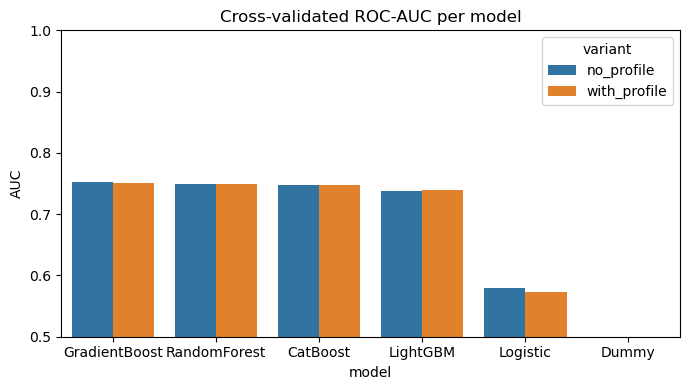

In [28]:
import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.barplot(data=leader, x='model', y='AUC', hue='variant')
plt.title('Cross-validated ROC-AUC per model')
plt.ylim(0.5, 1)
plt.tight_layout(); plt.show()

In [29]:
best_pipe = joblib.load('learnnavi_best_model.pkl')

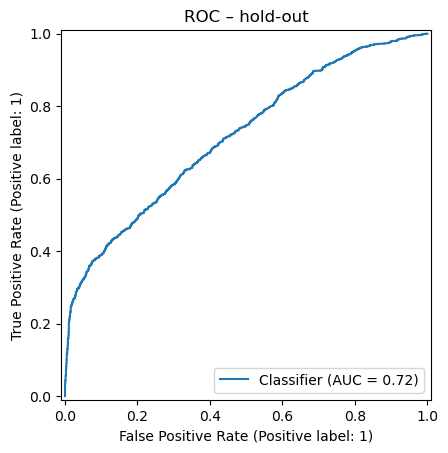

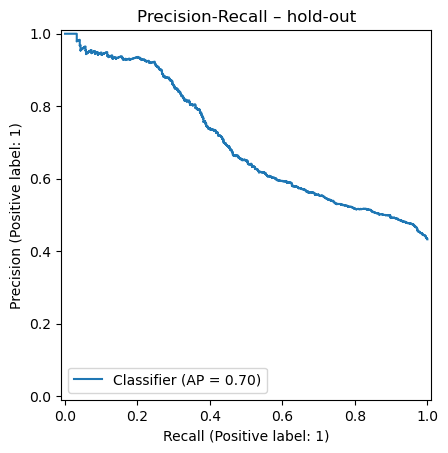

In [30]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=False)
best_pipe.fit(X_train, y_train)
prob = best_pipe.predict_proba(X_hold)[:,1]

RocCurveDisplay.from_predictions(y_hold, prob)
plt.title('ROC – hold-out'); plt.show()

PrecisionRecallDisplay.from_predictions(y_hold, prob)
plt.title('Precision-Recall – hold-out'); plt.show()

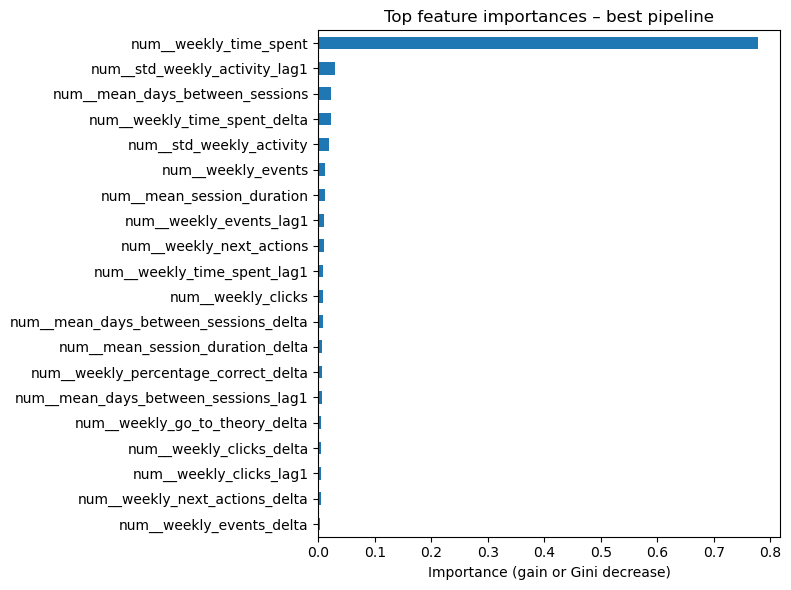

In [31]:
import joblib, pandas as pd, matplotlib.pyplot as plt

# ------------ CONFIG -------------------------------------------------
MODEL_PATH = 'learnnavi_best_model.pkl'   # adjust if you saved under another name
TOPN       = 20                           # top features to display
# --------------------------------------------------------------------

# Load model
best_pipe = joblib.load(MODEL_PATH)

# Extract feature names after preprocessing
if hasattr(best_pipe, 'named_steps'):
    # sklearn Pipeline path
    preproc = best_pipe.named_steps.get('columntransformer', None) or \
              best_pipe.named_steps.get('columntransformer0', None) or \
              [s for s in best_pipe.named_steps.values() if isinstance(s, type(best_pipe)).__name__=='ColumnTransformer'][0]
    model   = [s for s in best_pipe.named_steps.values() if s is not preproc][-1]
    feat_names = preproc.get_feature_names_out()
else:
    # CatBoost path (model alone)
    model = best_pipe
    feat_names = [f'feat_{i}' for i in range(model.feature_count_)]

# Handle RandomForest / GBDT / LightGBM feature importance attribute
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
elif hasattr(model, 'coef_'):
    importances = model.coef_.flatten()
else:
    raise ValueError("Model type not supported for visualisation in this snippet.")

# Build DataFrame and sort
fi = (pd.Series(importances, index=feat_names)
        .sort_values(ascending=False)
        .head(TOPN))

# Plot
plt.figure(figsize=(8,6))
fi.sort_values().plot(kind='barh')
plt.title('Top feature importances – best pipeline')
plt.xlabel('Importance (gain or Gini decrease)')
plt.tight_layout()
plt.show()

### Feature insight & next-step plan

* **Weekly time-spent** dominates the importance chart.  
  It is effectively a “master” variable that already reflects most other actions
  (clicks, sessions, quiz attempts, etc.).  
  As a result, finer-grained features receive almost no visible weight.

* **Objective reminder** – we want to **understand which concrete behaviours
  influence retention**, not just maximise raw accuracy.

* **Planned follow-up**  
  1. **Re-train without time-spent (or with it capped/normalised)** to let other
     signals surface.  
  2. Compare new SHAP / importance plots to identify which specific actions
     (quiz correctness, early-morning study, regularity gaps, …) gain influence
     once pure volume is out of the way.  

This ablation will show whether those behaviours have *independent* predictive
power and therefore are actionable levers for boosting retention.

---

### Why these evaluation metrics?

| Metric | Why we chose it |
|--------|-----------------|
| **ROC-AUC** | Measures ranking quality over *all* thresholds; good global view when the label is roughly balanced (≈50 / 50). |
| **Precision-Recall (Average Precision)** | Focuses on the **positive class** (learners who churn). Relevant because interventions cost resources and we care about hit-rate among flagged users. |
| **F1 at 0.5 threshold** | Single-number blend of precision & recall for a default operating point; easy to compare models for “flag / don’t-flag” decisions. |

Using all three lets us:  
* ensure the model ranks learners well overall (AUC),  
* verify it’s efficient when we act on only a subset (PR), and  
* check a concrete yes/no cut-off (F1).

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

All team members contributed to refining the research question and developing the project plan by reviewing relevant literature, including papers recommended by the teaching assistants.

*Nino* was primarily responsible for data preprocessing and feature engineering, including the weekly aggregation and construction of behavioral dimensions. *Omar* implemented and evaluated the machine learning models, conducted the ablation study, and generated performance metrics. *Valentine* led the writing of the report, integrating results and literature references into a coherent narrative.

Overall, the collaboration went smoothly and the workload was distributed fairly among team members. However, we underestimated the time required to complete certain tasks, which resulted in a time crunch near the final deadline. For future milestones, we plan to not only assign responsibilities earlier but also define internal deadlines to track progress and avoid last-minute pressure.
*Your discussion about team responsibilities goes here*

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# ---------------------- CONFIG -----------------------------
SEQ_LEN = 5
BATCH_SIZE = 128
EPOCHS = 50
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------------------- DATASET PREP ------------------------
df = user_week_features.sort_values(['user_id', 'year_week']).copy()
drop_cols = ['user_id', 'year_week', 'engaged_next_week']
features = df.select_dtypes(include='number').drop(columns=['engaged_next_week']).columns.tolist()

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split by user to avoid leakage
user_ids = df['user_id'].unique()
train_ids, temp_ids = train_test_split(user_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

def build_sequences(user_ids_subset):
    X, y = [], []
    for uid in user_ids_subset:
        group = df[df['user_id'] == uid].reset_index(drop=True)
        for i in range(len(group) - SEQ_LEN):
            seq = group.loc[i:i+SEQ_LEN-1, features].values
            label = group.loc[i+SEQ_LEN, 'engaged_next_week']
            if label in [0, 1]:
                X.append(seq)
                y.append(float(label))
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)

X_train, y_train = build_sequences(train_ids)
X_val, y_val     = build_sequences(val_ids)
X_test, y_test   = build_sequences(test_ids)

# Dataset class
class WeeklySequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(WeeklySequenceDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(WeeklySequenceDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader  = DataLoader(WeeklySequenceDataset(X_test, y_test), batch_size=BATCH_SIZE)

# ---------------------- MODEL -----------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out)

model = LSTMClassifier(input_dim=X_train.shape[2]).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ---------------------- TRAINING -----------------------------
for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Eval
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(DEVICE)
            out = model(batch_x).cpu().numpy()
            val_preds.extend(out)
            val_true.extend(batch_y.numpy())

    val_preds = np.array(val_preds).flatten()
    val_true = np.array(val_true).flatten()
    val_auc = roc_auc_score(val_true, val_preds)
    val_f1  = f1_score(val_true, (val_preds >= 0.5).astype(int))

    print(f"Epoch {epoch+1:02d} | Train Loss: {np.mean(train_losses):.4f} | Val AUC: {val_auc:.3f} | Val F1: {val_f1:.3f}")

# ---------------------- TEST EVALUATION ----------------------
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(DEVICE)
        out = model(batch_x).cpu().numpy()
        test_preds.extend(out)
        test_true.extend(batch_y.numpy())

test_preds = np.array(test_preds).flatten()
test_true = np.array(test_true).flatten()
test_auc = roc_auc_score(test_true, test_preds)
test_f1  = f1_score(test_true, (test_preds >= 0.5).astype(int))

print(f"\n✅ Test AUC: {test_auc:.3f} | Test F1: {test_f1:.3f}")


Epoch 01 | Train Loss: 0.6777 | Val AUC: 0.591 | Val F1: 0.172
Epoch 02 | Train Loss: 0.6684 | Val AUC: 0.593 | Val F1: 0.279
Epoch 03 | Train Loss: 0.6654 | Val AUC: 0.598 | Val F1: 0.335
Epoch 04 | Train Loss: 0.6625 | Val AUC: 0.602 | Val F1: 0.444
Epoch 05 | Train Loss: 0.6610 | Val AUC: 0.604 | Val F1: 0.382
Epoch 06 | Train Loss: 0.6589 | Val AUC: 0.609 | Val F1: 0.415
Epoch 07 | Train Loss: 0.6572 | Val AUC: 0.611 | Val F1: 0.384
Epoch 08 | Train Loss: 0.6551 | Val AUC: 0.610 | Val F1: 0.381
Epoch 09 | Train Loss: 0.6546 | Val AUC: 0.615 | Val F1: 0.389
Epoch 10 | Train Loss: 0.6526 | Val AUC: 0.620 | Val F1: 0.402
Epoch 11 | Train Loss: 0.6516 | Val AUC: 0.618 | Val F1: 0.366
Epoch 12 | Train Loss: 0.6498 | Val AUC: 0.622 | Val F1: 0.464
Epoch 13 | Train Loss: 0.6481 | Val AUC: 0.624 | Val F1: 0.426
Epoch 14 | Train Loss: 0.6473 | Val AUC: 0.624 | Val F1: 0.445
Epoch 15 | Train Loss: 0.6453 | Val AUC: 0.624 | Val F1: 0.411
Epoch 16 | Train Loss: 0.6435 | Val AUC: 0.623 | Val F1

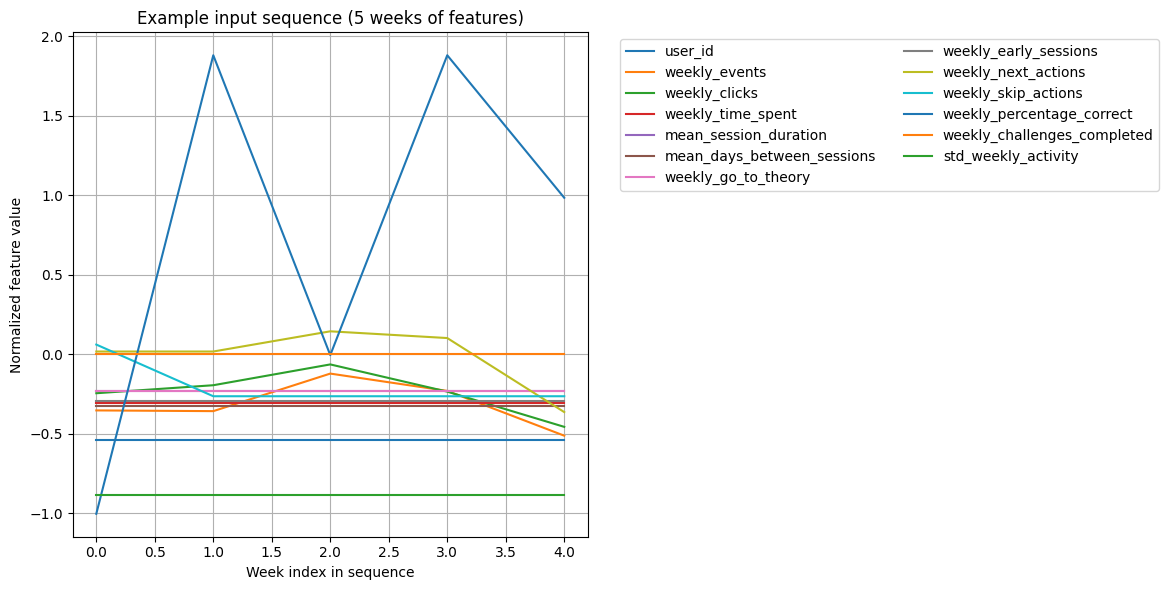

True label: 0
Predicted probability of engagement: 0.167


In [19]:
import matplotlib.pyplot as plt

# Pick a random test sample
i = np.random.randint(len(X_test))
example_seq = X_test[i]  # shape: (5, num_features)

plt.figure(figsize=(12, 6))
for f_idx in range(example_seq.shape[1]):
    plt.plot(range(SEQ_LEN), example_seq[:, f_idx], label=features[f_idx])

plt.title("Example input sequence (5 weeks of features)")
plt.xlabel("Week index in sequence")
plt.ylabel("Normalized feature value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.grid(True)
plt.show()

print(f"True label: {int(y_test[i][0])}")
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(example_seq[None, ...], dtype=torch.float32).to(DEVICE)
    pred = model(input_tensor).item()
print(f"Predicted probability of engagement: {pred:.3f}")


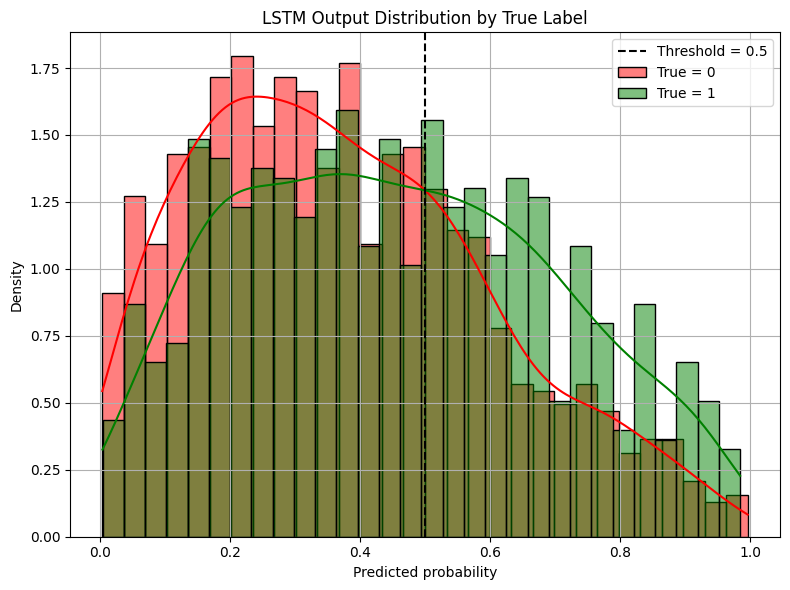

In [20]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(test_preds[test_true == 0], bins=30, label='True = 0', color='red', kde=True, stat='density')
sns.histplot(test_preds[test_true == 1], bins=30, label='True = 1', color='green', kde=True, stat='density')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("LSTM Output Distribution by True Label")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


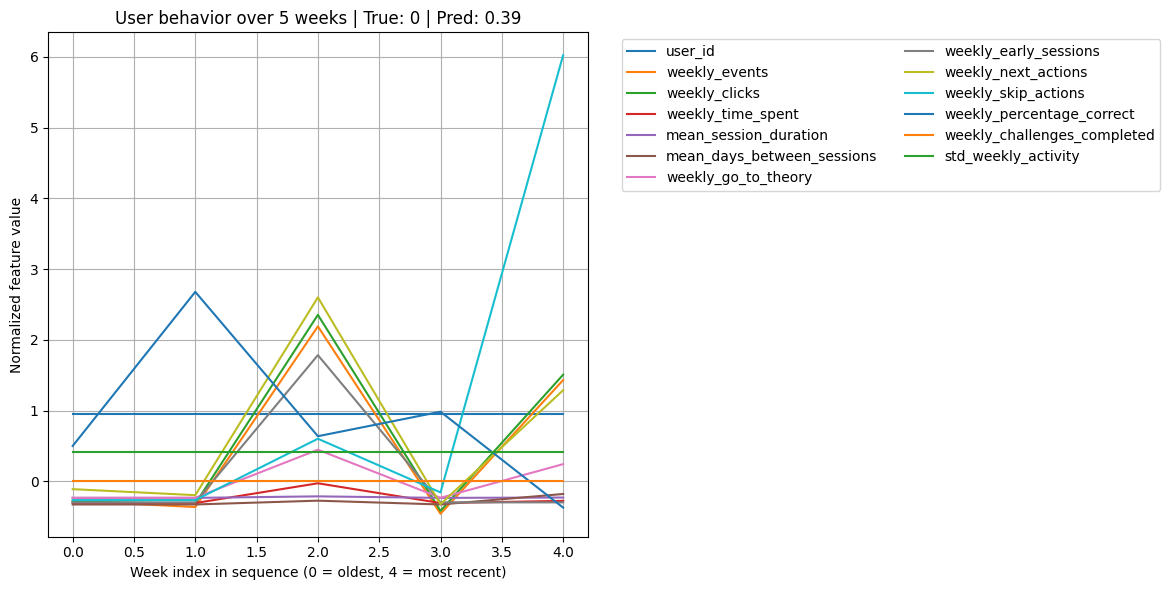

In [21]:
import matplotlib.pyplot as plt

# Pick a random example from the test set
i = np.random.randint(len(X_test))
seq = X_test[i]  # shape: (5, num_features)
true_label = int(y_test[i][0])

# Predict with model
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(seq[None, ...], dtype=torch.float32).to(DEVICE)
    pred_prob = model(input_tensor).item()

# Plot
plt.figure(figsize=(12, 6))
for f in range(seq.shape[1]):
    plt.plot(range(SEQ_LEN), seq[:, f], label=features[f])

plt.title(f"User behavior over 5 weeks | True: {true_label} | Pred: {pred_prob:.2f}")
plt.xlabel("Week index in sequence (0 = oldest, 4 = most recent)")
plt.ylabel("Normalized feature value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


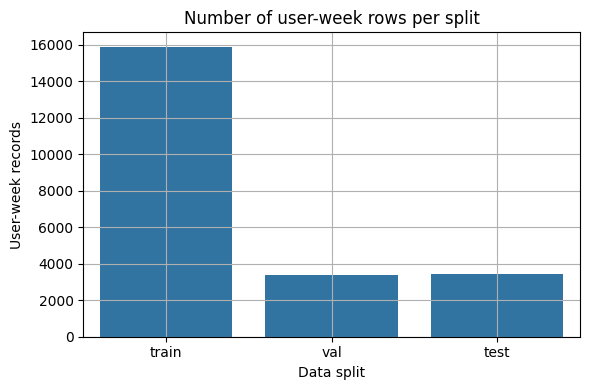

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Label each row in df with its split
df['split'] = 'unknown'
df.loc[df['user_id'].isin(train_ids), 'split'] = 'train'
df.loc[df['user_id'].isin(val_ids), 'split'] = 'val'
df.loc[df['user_id'].isin(test_ids), 'split'] = 'test'

# Count user-weeks per split
split_counts = df['split'].value_counts().reindex(['train', 'val', 'test'])

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=split_counts.index, y=split_counts.values)
plt.title("Number of user-week rows per split")
plt.ylabel("User-week records")
plt.xlabel("Data split")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
print(f"Train users: {len(train_ids)}")
print(f"Val users  : {len(val_ids)}")
print(f"Test users : {len(test_ids)}")

# Sanity check – any overlaps?
print("Overlap (train ∩ val):", len(set(train_ids) & set(val_ids)))
print("Overlap (train ∩ test):", len(set(train_ids) & set(test_ids)))
print("Overlap (val ∩ test):", len(set(val_ids) & set(test_ids)))


Train users: 1339
Val users  : 287
Test users : 287
Overlap (train ∩ val): 0
Overlap (train ∩ test): 0
Overlap (val ∩ test): 0


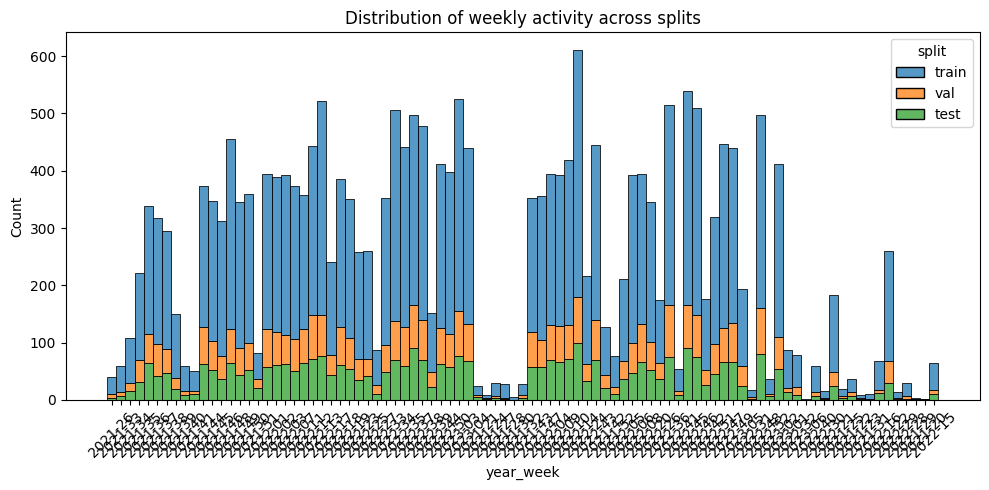

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='year_week', hue='split', multiple='stack', bins=50)
plt.title("Distribution of weekly activity across splits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
